# Draft of H3 evaluation
grid-cell wise comparison of metrics
* `base`: the ground truth (manually simplified)
* `comp`: the method to compare (for now, as example: the parenx/voronoi simplification)

In [1]:
import geopandas as gpd
import pandas as pd
import os
import glob
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors
import h3 
import osmnx as ox
import numpy as np
from shapely import strtree
from shapely.geometry import mapping, Polygon, Point
import utils
import contextily as cx
import momepy as mm
import networkx as nx
from collections import Counter

helper funcs (possibly move to utils later)

In [2]:
def add_node_degree(gdf, graph):
    gdf["degree"] = gdf.apply(lambda x: nx.degree(graph, x.nodeID), axis = 1)
    return gdf

settings

In [3]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

base_crs = "EPSG:4326"

# baseinal OSM data
orig_file = f'../data/{fua}/roads_osm.parquet'

# which file to take as baseline?
base_file = f"../data/{fua}/manual/{fua}.parquet"

read in metadata for this FUA

In [4]:
meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

read in original OSM data, and base (manual) and comp (automated method) datasets

In [5]:
# read in orig OSM data
orig = utils.read_parquet_roads(fua)
orig = orig[["geometry"]]

# read in base case (manual simp)
base = utils.read_manual(fua, proj_crs = orig.crs)

# which file to compare with?
comp = utils.read_parenx(
    fua, 
    "voronoi", 
    proj_crs = orig.crs
)

/Users/anvy/Library/CloudStorage/OneDrive-ITU/projects/simplification/code/utils.py:195: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf = gdf.explode(ingore_index=True)


In [6]:
# get graphs & node/edge gdfs for both data sets
base_graph = mm.gdf_to_nx(base, length="length", integer_labels=True)
comp_graph = mm.gdf_to_nx(comp, length="length", integer_labels=True)
nodes_base, edges_base = mm.nx_to_gdf(base_graph)
nodes_comp, edges_comp = mm.nx_to_gdf(comp_graph)
# add node degree to nodes df
nodes_base = add_node_degree(nodes_base, base_graph)
nodes_comp = add_node_degree(nodes_comp, comp_graph)


# Making h3 grid for this FUA

In [7]:
grid = utils.make_grid(fua, res, proj_crs = orig.crs)
grid.head()

,hex_id,geometry
0,89bb500338bffff,"POLYGON ((307425.076 -4083037.824, 307332.523 ..."
1,89bb5002e53ffff,"POLYGON ((299849.826 -4082107.963, 299757.203 ..."
2,89bb5002077ffff,"POLYGON ((300926.180 -4085092.718, 300833.565 ..."
3,89bb501adc3ffff,"POLYGON ((309731.142 -4092124.670, 309638.603 ..."
4,89bb5002e87ffff,"POLYGON ((298302.513 -4082579.814, 298209.875 ..."


In [8]:
assert grid.crs == base.crs
assert grid.crs == comp.crs

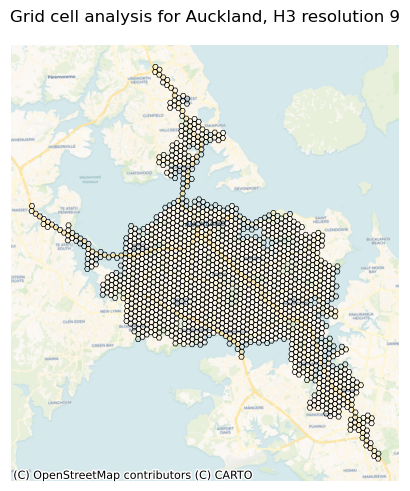

In [9]:
fig, ax = plt.subplots(1,1, figsize = (5,8)) 
ax.set_axis_off()
# base.plot(ax=ax, linewidth = 0.1, alpha = 0.5, color = "blue")
grid.boundary.plot(ax=ax, linewidth = 0.5, alpha = 1, color = "black")
ax.set_title(f'Grid cell analysis for {city}, H3 resolution {res}');
cx.add_basemap(ax=ax, crs = grid.crs, source=cx.providers.CartoDB.Voyager)

# Cell-wise evaluation

For evaluation: add gridcell-wise analysis of metrics:
* `geom_count`: computes total nr of geoms in a cell (after `clip`ping) 
* `cell_length`: computes total length of geoms in a cell
* `node_count`: number of nodes in cell
* `degree_distr`: node degree distribution in cell 
* `avg_degree`: average node degree in cell
* displacement
* feature matching

For use cases: 
* code to zoom in to separate gridcells for use case checking

In [10]:
def geom_count(gdf, geom):
    return len(gpd.clip(gdf, geom))

def cell_length(gdf, geom):
    return gpd.clip(gdf, geom).length.sum()

def node_count(node_gdf, geom):
    return len(gpd.clip(node_gdf, geom))

def degree_distr(node_gdf, geom):
    return dict(Counter(gpd.clip(node_gdf, geom)["degree"]))

def avg_degree(histdict):
    if len(histdict) > 0:
        return sum([k*v for k, v in histdict.items()]) / sum([v for v in histdict.values()]) 
    return 0

In [11]:
# geom counts in cell
grid["geom_count_base"] = grid.apply(lambda x: geom_count(base, x.geometry), axis = 1)
grid["geom_count_comp"] = grid.apply(lambda x: geom_count(comp, x.geometry), axis = 1)

# geom lengths in cell
grid["cell_length_base"] = grid.apply(lambda x: cell_length(base, x.geometry), axis = 1)
grid["cell_length_comp"] = grid.apply(lambda x: cell_length(comp, x.geometry), axis = 1)

# node count in cell
grid["node_count_base"] = grid.apply(lambda x: node_count(nodes_base, x.geometry), axis =1)
grid["node_count_comp"] = grid.apply(lambda x: node_count(nodes_comp, x.geometry), axis =1)

# node degree distributions in cell
grid["node_degrees_base"] = grid.apply(lambda x: degree_distr(nodes_base, x.geometry), axis = 1)
grid["node_degrees_comp"] = grid.apply(lambda x: degree_distr(nodes_comp, x.geometry), axis = 1)

# average node degree per cell
grid["avg_degree_base"] = grid.apply(lambda x: avg_degree(x.node_degrees_base), axis = 1)
grid["avg_degree_comp"] = grid.apply(lambda x: avg_degree(x.node_degrees_comp), axis = 1)

In [12]:
for var in ["geom_count", "cell_length", "node_count", "avg_degree"]:
    grid[f"{var}_ratio"] = grid[f"{var}_comp"] / grid[f"{var}_base"]

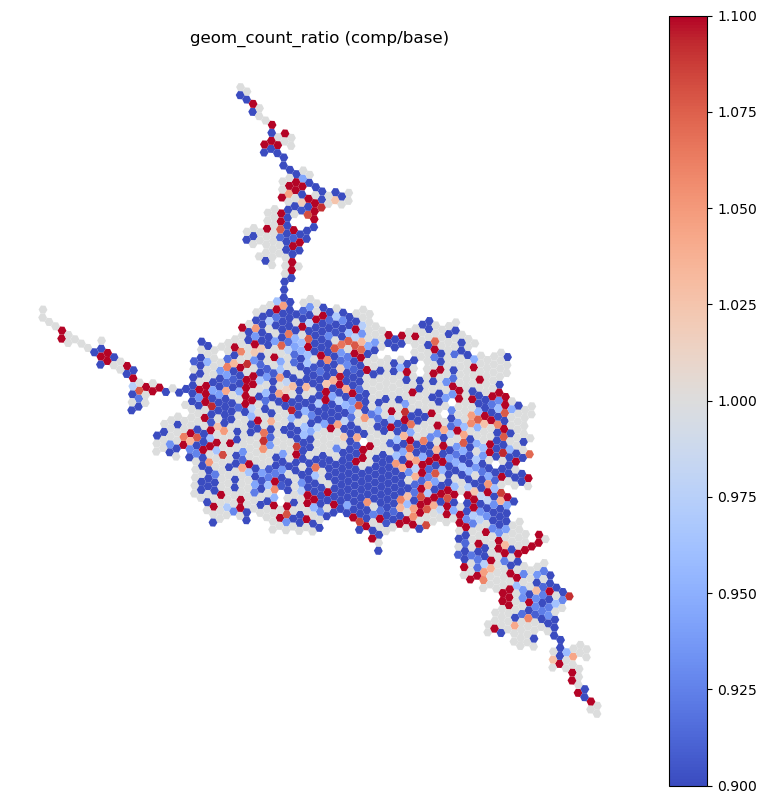

In [13]:
var = "geom_count_ratio"
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax,
    column = var, 
    norm=colors.CenteredNorm(vcenter=1), 
    cmap=cmap, 
    legend = True
    )
ax.set_title(f"{var} (comp/base)");

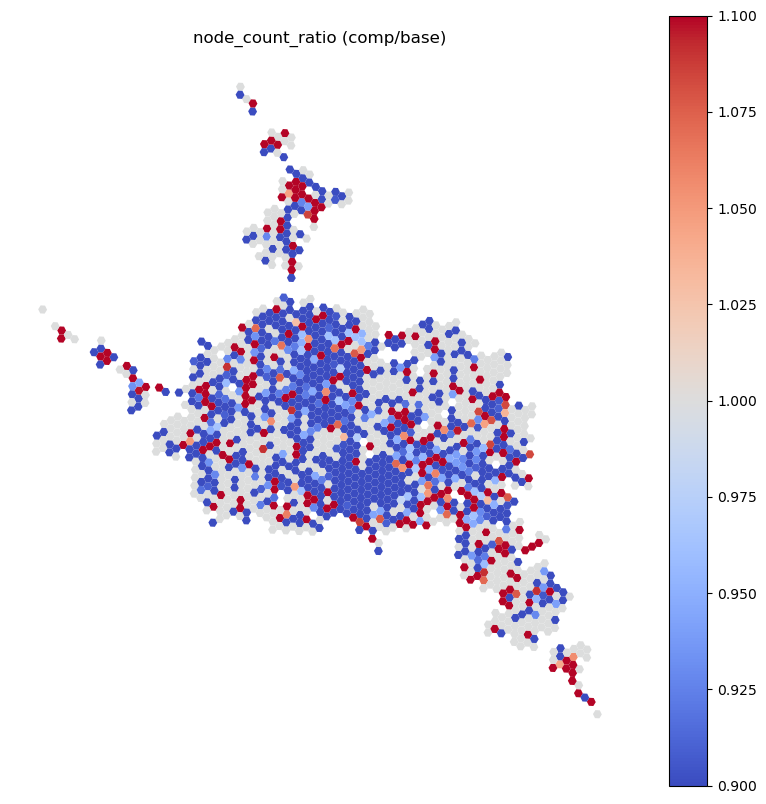

In [14]:
var = "node_count_ratio"
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax,
    column = var, 
    norm=colors.CenteredNorm(vcenter=1), 
    cmap=cmap, 
    legend = True
    )
ax.set_title(f"{var} (comp/base)");

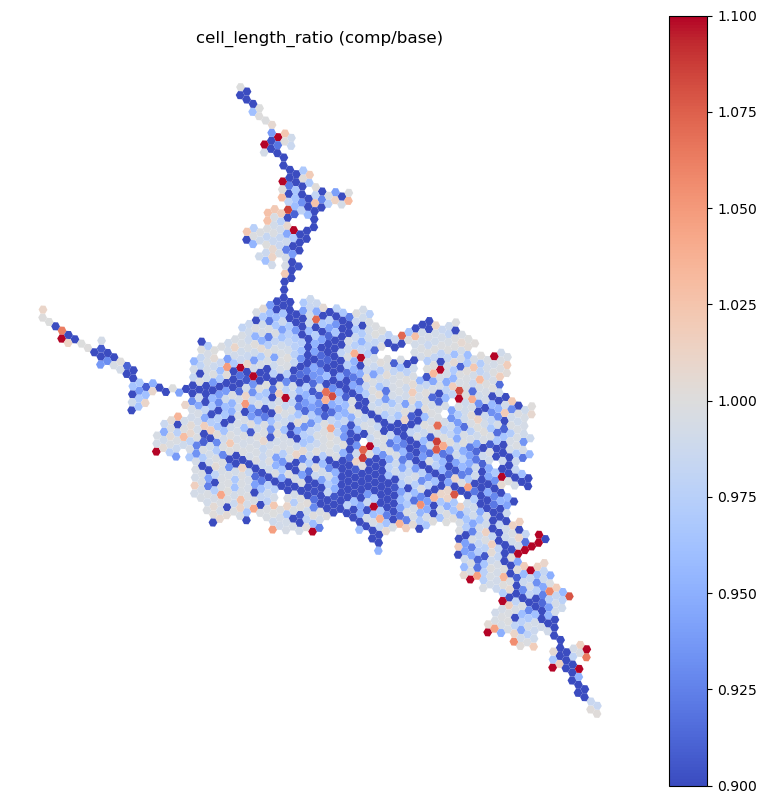

In [15]:
var = "cell_length_ratio"
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax,
    column = var, 
    norm=colors.CenteredNorm(vcenter=1), 
    cmap=cmap, 
    legend = True
    )
ax.set_title(f"{var} (comp/base)");

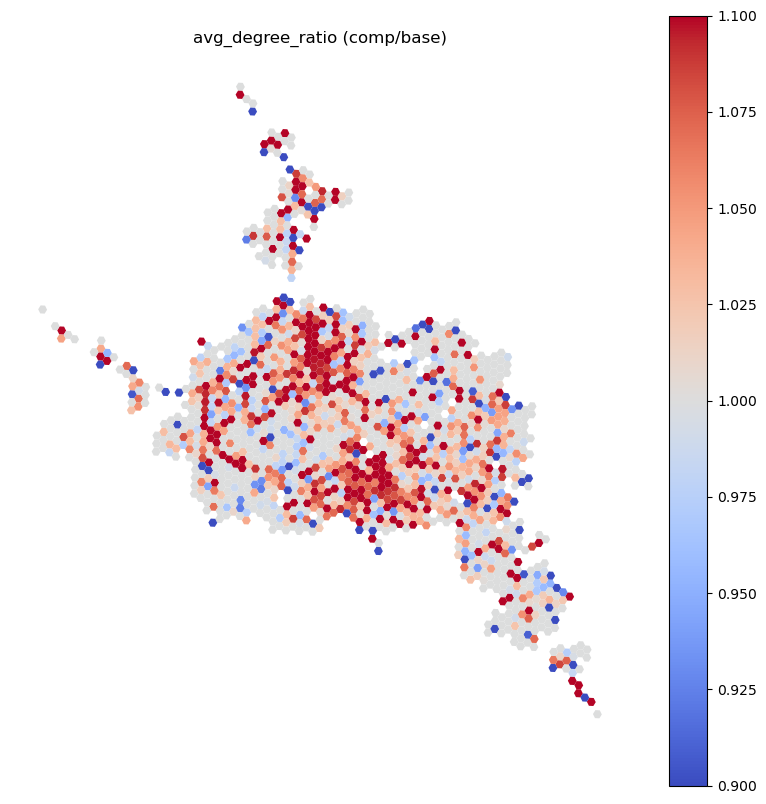

In [16]:
var = "avg_degree_ratio"
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.set_axis_off()
cmap = cm.coolwarm
grid.plot(
    ax=ax,
    column = var, 
    norm=colors.CenteredNorm(vcenter=1), 
    cmap=cmap, 
    legend = True
    )
ax.set_title(f"{var} (comp/base)");

# Zoom-in plot of one specific grid cell

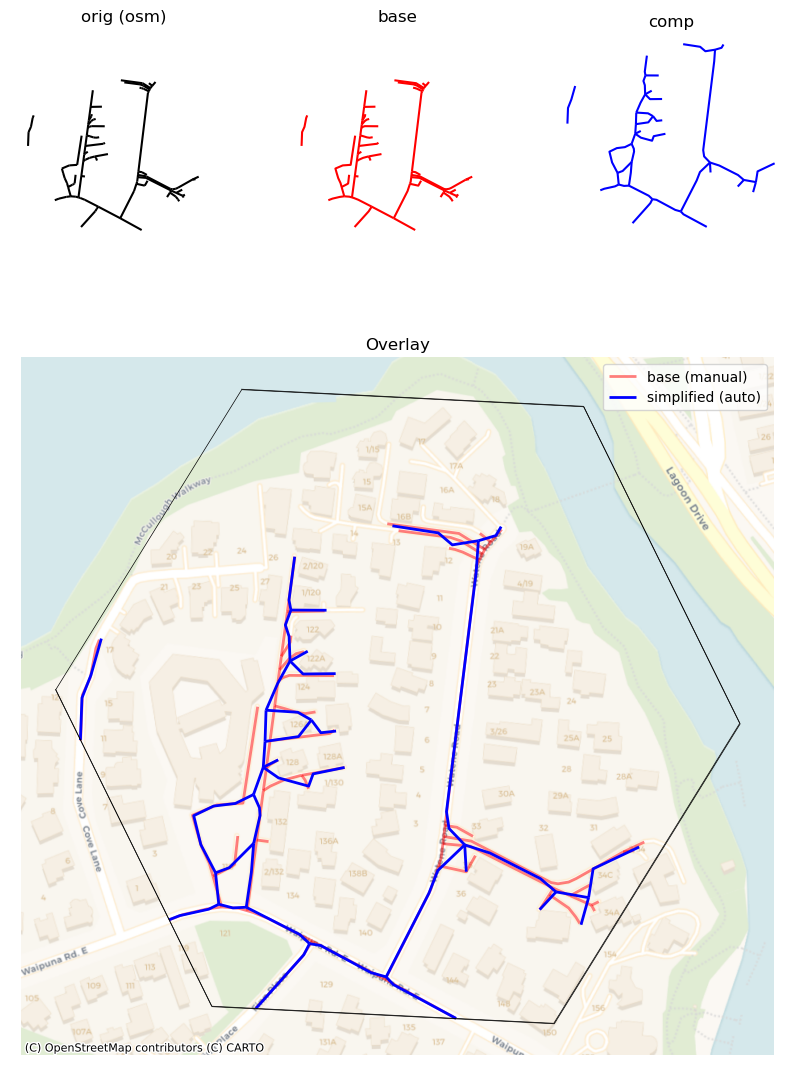

In [37]:
grid_id = 27 # which cell to plot
fig, ax = utils.plot_cell(grid_id, grid, orig, base, comp)
plt.show()

## Generate single cell plots 
... for top 10 instances where total geom length in comp is higher than in manual

In [38]:
subfolder = f"../usecases/{fua}/totallength/"
os.makedirs(subfolder, exist_ok=True)
cells_to_plot = grid[grid.cell_length_ratio > 1].sort_values(by="cell_length_ratio", ascending=False).index[0:10]

In [39]:
for id in cells_to_plot:
    ratio = np.round(grid.loc[id, "cell_length_ratio"], 3)
    fig, ax = utils.plot_cell(id, grid=grid, orig=orig, base=base, comp=comp)
    plt.suptitle(f"Total length ratio comp/base: {ratio}")
    plt.tight_layout()
    fig.savefig(subfolder + f"{id}.png", dpi = 300, bbox_inches = "tight")
    plt.close()

## Generate single cell plots 
... for top 10 instances where average node degree in comp is lower than in manual

In [40]:
subfolder = f"../usecases/{fua}/averagedegree/"
os.makedirs(subfolder, exist_ok=True)
cells_to_plot = grid[
    (grid.avg_degree_ratio < 1) & (grid.avg_degree_ratio > 0)].sort_values(
        by="avg_degree_ratio", ascending=True
        ).index[0:10]

for id in cells_to_plot:
    ratio = np.round(grid.loc[id, "avg_degree_ratio"], 3)
    fig, ax = utils.plot_cell(id, grid=grid, orig=orig, base=base, comp=comp)
    plt.suptitle(f"Average node degree ratio comp/base: {ratio}")
    plt.tight_layout()
    fig.savefig(subfolder + f"{id}.png", dpi = 300, bbox_inches = "tight")
    plt.close()